In [1]:
import sys
import pandas as pd
pd.set_option('display.max_columns', 100)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from glob import glob
from tqdm import tqdm
import random
import time

In [2]:
# provide the path to your local installation of the CROPseq-multi package
CSM_dir = '/'.join(os.getcwd().split('/')[:-1])
os.chdir(CSM_dir)
sys.path.append(CSM_dir+'/csm')

import guide_selection, barcode_selection, oligo_design

# overview

1) **select sgRNA spacer pairs** - In this example, we will import a CRISPick output file and pair guides targeting the same gene. We will add controls including nontargeting pairs, intergenic pairs, and olfactory receptor pairs.

2) **select iBAR pairs** 

3) **randomly assign tRNAs**

4) **generate oligos**

# 1. select sgRNA spacer pairs

### Load selected sgRNAs 

Here, the input to our pipeline is a CRISPick results file containing sgRNAs designed against selected target genes.

See: https://portals.broadinstitute.org/gppx/crispick/public
- use "Chen (2013) tracrRNA" model for guide selection
- design 1-2 additional sgRNAs per gene than you anticipate using
    - for example, if you will use 4 unique sgRNAs per gene, design 5-6 per gene with CRISPick.
    - the highest highest ranked guides will be prioritized.

In [3]:
# provide the path to your CRISPick guide design
guide_input_df = pd.read_table('input_files/CRISPick_output_single_target_example.txt')
guide_input_df

,Input,Quota,Target Taxon,Target Gene ID,Target Gene Symbol,Target Transcript,Target Alias,CRISPR Mechanism,Target Domain,Reference Sequence,Strand of Target,PAM Policy,Initial Spacing Requirement,Off-Target Match Ruleset Version,Off-Target Tier Policy,Off-Target Match Bin Policy,Strand of sgRNA,Orientation,sgRNA Cut Position (1-based),sgRNA Sequence,sgRNA Context Sequence,PAM Sequence,Exon Number,Target Cut Length,Target Total Length,Target Cut %,Other Target Matches,# Off-Target Tier I Match Bin I Matches,# Off-Target Tier II Match Bin I Matches,# Off-Target Tier III Match Bin I Matches,# Off-Target Tier IV Match Bin I Matches,# Off-Target Tier I Match Bin II Matches,# Off-Target Tier II Match Bin II Matches,# Off-Target Tier III Match Bin II Matches,# Off-Target Tier IV Match Bin II Matches,# Off-Target Tier I Match Bin III Matches,# Off-Target Tier II Match Bin III Matches,# Off-Target Tier III Match Bin III Matches,# Off-Target Tier IV Match Bin III Matches,# Off-Target Tier I Match Bin IV Matches,# Off-Target Tier II Match Bin IV Matches,# Off-Target Tier III Match Bin IV Matches,# Off-Target Tier IV Match Bin IV Matches,On-Target Ruleset,On-Target Efficacy Score,On-Target Rank,Off-Target Rank,On-Target Rank Weight,Off-Target Rank Weight,Combined Rank,Pick Order,Picking Round,Picking Notes
0,DONSON,6,9606,ENSG00000159147,DONSON,ENST00000303071.10,DONSON,CRISPRko,CDS,NC_000021.9,-,SpyoCas9,5,1,1,5.20.100,+,antisense,33583612,TAGGTACAAACGTAGAAATA,CTGATAGGTACAAACGTAGAAATAGGGGCA,GGG,5,840,1701,49.4,NaN,0,0,0,0,0,37,42,33,0,106,76,66,1,79,72,61,RS3seq-Chen2013+RS3target,1.3650,2,4,1,1,1,1,1,NaN
1,DONSON,6,9606,ENSG00000159147,DONSON,ENST00000303071.10,DONSON,CRISPRko,CDS,NC_000021.9,-,SpyoCas9,5,1,1,5.20.100,-,sense,33584674,CTACCACTGTTCCCTCGTAT,TTGGCTACCACTGTTCCCTCGTATTGGAGC,TGG,4,701,1701,41.2,NaN,0,0,0,0,1,13,20,5,1,34,38,20,4,63,49,21,RS3seq-Chen2013+RS3target,0.3165,39,10,1,1,7,2,1,NaN
2,DONSON,6,9606,ENSG00000159147,DONSON,ENST00000303071.10,DONSON,CRISPRko,CDS,NC_000021.9,-,SpyoCas9,5,1,1,5.20.100,-,sense,33583493,AGAGAAGCTATGAGAAATGA,TTTAAGAGAAGCTATGAGAAATGAAGGTAA,AGG,5,959,1701,56.4,NaN,0,0,0,1,2,197,159,110,2,201,190,122,11,296,367,272,RS3seq-Chen2013+RS3target,0.8049,10,65,1,1,15,3,1,NaN
3,DONSON,6,9606,ENSG00000159147,DONSON,ENST00000303071.10,DONSON,CRISPRko,CDS,NC_000021.9,-,SpyoCas9,5,1,1,5.20.100,+,antisense,33588494,AAGAGGCAGCCCCGCCACCA,GGCGAAGAGGCAGCCCCGCCACCAGGGCGG,GGG,1,148,1701,8.7,NaN,0,1,0,0,1,61,42,25,18,143,98,72,47,282,176,109,RS3seq-Chen2013+RS3target,0.6806,15,82,1,1,21,4,1,NaN
4,DONSON,6,9606,ENSG00000159147,DONSON,ENST00000303071.10,DONSON,CRISPRko,CDS,NC_000021.9,-,SpyoCas9,5,1,1,5.20.100,-,sense,33586016,AGGTCTTGTCCAGCATTGTA,CTCAAGGTCTTGTCCAGCATTGTAGGGCAA,GGG,3,568,1701,33.4,ENSG00000249209,1,0,0,0,1,39,33,24,3,76,66,44,1,86,88,56,RS3seq-Chen2013+RS3target,0.8889,7,197,1,1,79,5,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1405,EIF6,6,9606,ENSG00000242372,EIF6,ENST00000374450.8,EIF6,CRISPRko,CDS,NC_000020.11,-,SpyoCas9,5,1,1,5.20.100,-,sense,35284181,ATCATCGGGCGCATGTGTGT,CCGCATCATCGGGCGCATGTGTGTGGGTAA,GGG,3,188,738,25.5,NaN,0,0,0,0,1,33,17,17,2,17,13,10,3,30,21,9,RS3seq-Chen2013+RS3target,0.9347,9,9,1,1,2,2,1,NaN
1406,EIF6,6,9606,ENSG00000242372,EIF6,ENST00000374450.8,EIF6,CRISPRko,CDS,NC_000020.11,-,SpyoCas9,5,1,1,5.20.100,-,sense,35280791,ACCCAACAATACCACCGACC,TGGTACCCAACAATACCACCGACCAGGAGC,AGG,4,232,738,31.4,NaN,0,0,0,0,2,47,22,24,3,34,23,23,5,29,16,13,RS3seq-Chen2013+RS3target,0.9553,6,15,1,1,3,3,1,NaN
1407,EIF6,6,9606,ENSG00000242372,EIF6,ENST00000374450.8,EIF6,CRISPRko,CDS,NC_000020.11,-,SpyoCas9,5,1,1,5.20.100,+,antisense,35280055,GCTTCCTACTAGCACCTGGT,AGTAGCTTCCTACTAGCACCTGGTCGGCCA,CGG,5,433,738,58.7,NaN,0,0,0,0,2,64,41,31,2,59,45,36,1,184,169,115,RS3seq-Chen2013+RS3target,0.9552,7,20,1,1,5,4,1,NaN
1408,EIF6,6,9606,

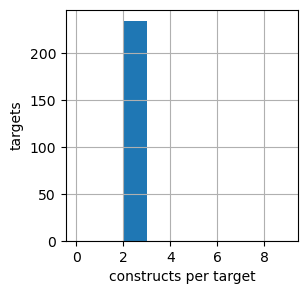

In [4]:
gene_targeting_pairs = guide_selection.pair_guides_single_target_CRISPick(
    guide_input_df, 
    constructs_per_gene = 2,
    pairing_method='pick_sum'
)

gene_targeting_pairs['category']='GENE_TARGETING'

plt.figure(figsize=(3,3))
gene_targeting_pairs.value_counts('target').hist(bins=range(0,10))
plt.xlabel('constructs per target')
plt.ylabel('targets')
plt.show()

### now let's add some controls

For CRISPR-KO, nontargeting guides (non-cutting controls), intergenic targeting guides (intergenic cutting controls), and olfactory receptor targeting guides (gene-cutting controls) are all valid controls. Let's add some of each.

In [5]:
control_pairs_df = guide_selection.pair_guides_single_target_controls(
    n_OR_genes = 50, # number of olfactory receptor genes to use as controls
    n_OR_constructs_per_gene = 2, # number of constructs to design per olfactory receptor gene target
    n_intergenic_constructs = 100, # number of intergenic control constructs
    n_nontargeting_constructs = 100, # number of nontargeting control constructs
    modality = 'CRISPRko', # 'CRISPRko', 'CRISPRi', or 'CRISPRa'
)

### combine gene-targeting and control pairs

In [6]:
guide_pairs_df = pd.concat([ gene_targeting_pairs, control_pairs_df],
                           ignore_index=True).reset_index(drop=True)
    
guide_pairs_df

,target,target_symbol,spacer_1,spacer_2,spacer_1_pick_order,spacer_2_pick_order,target_version,category
0,ENSG00000004897,CDC27,AAAGTTCTGGTCCACAAACA,GCAACCTGTTATTACCGCTC,4,1,1,GENE_TARGETING
1,ENSG00000004897,CDC27,CTGTGAGATAAACTATGATT,ATGATTCAAAGGGAGACCAG,3,2,2,GENE_TARGETING
2,ENSG00000007168,PAFAH1B1,TGTATGGGTCGTAGCAACAA,GAATGCATCAGAACCATGCA,1,4,1,GENE_TARGETING
3,ENSG00000007168,PAFAH1B1,ACACAGAGAATGGGTACGTA,AGGACATACAGACTCTGTAC,2,3,2,GENE_TARGETING
4,ENSG00000011600,TYROBP,GCTGACAGTGCTCATTGCCC,GTGCTGGCAGGGATCGTGAT,4,1,1,GENE_TARGETING
...,...,...,...,...,...,...,...,...
765,INTERGENIC_CONTROL_Chr_X,INTERGENIC_CONTROL_Chr_X,ATAGTGGAAGGACGATAATT,AAAGTTACGAGGCACACTAA,1,2,1,INTERGENIC_CONTROL
766,INTERGENIC_CONTROL_Chr_X,INTERGENIC_CONTROL_Chr_X,AAAGCGCCTATAGTCCATAT,GAATAGCGTAGGGTTTCATA,2,1,1,INTERGENIC_CONTROL
767,INTERGENIC_CONTROL_Chr_X,INTERGENIC_CONTROL_Chr_X,AATTCTACGCCCTACCACAT,AAATAGGGTCAATATACCTC,1,2,1,INTERGENIC_CONTROL
768,INTERGENIC_CONTROL_Chr_X,INTERGENIC_CONTROL_Chr_X,TCAGTCTAACGGTACATGAT,AGAATGTAAATAGACGATCA,1,2,1,INTERGENIC_CONTROL


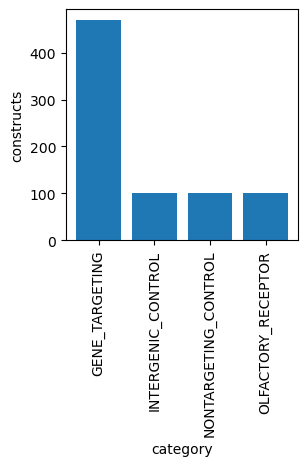

In [7]:
plt.figure(figsize=(3,3))
plt.bar(guide_pairs_df.value_counts('category').index,
        guide_pairs_df.value_counts('category').values)
plt.xlabel('category')
plt.xticks(rotation=90)
plt.ylabel('constructs')
plt.show()

# 2. iBAR selection

## A brief overview of methods for iBAR pairing

There are diverse ways to encode information in iBARs, with some methods offering distinct advantages. We have implemented a few methods, described below.

For optical pooled screening applications, consider if you will employ multiplexed decoding (mRNA detection) or serial decoding (T7-IVT detection).

### 1) 'positional'
- all iBARs are unique (iBARs are *not* repeated in either position) and iBAR position is encoded in the first base identity
    - iBAR1 starts with 'A' or 'G' (5'-3' mRNA/T7-IVT orientation)
    - iBAR2 starts with 'C' or 'T' (5'-3' mRNA/T7-IVT orientation)
- there is a guaranteed edit distance between all iBARs in a library
- compatible with repurposing iBAR2 as a unique molecular identifier
- for optical pooled screens:
    - multiplexed decoding (mRNA) enables recombination detection and more efficient decoding
        - observation of either barcode alone is sufficient to identify a construct
    - for serial decoding (T7-IVT), modestly less efficient decoding vs 'random_shared', 'random_unique', or 'matched'

### 2) 'random_unique'
- all iBARs are unique (iBARs are *not* repeated in either position) 
- there is a guaranteed edit distance between all iBARs in the library
- compatible with repurposing iBAR2 as a unique molecular identifier
- for optical pooled screens:
    - multiplexed decoding (mRNA) enables recombination detection and more efficient decoding
        - observation of either barcode alone is sufficient to identify a construct, even if the position (iBAR1 or iBAR2) is unknown

### 3) 'random_shared'
- iBARs are unique to a position (i.e. iBAR1 or iBAR2) but shared between positions (iBARs *may be* repeated between positions 1 and 2)
    - iBAR pairs are unique, independent of position (we do not allow BC1-BC2 and BC2-BC1 to co-occur)
- there is a guaranteed edit distance between all iBARs in a position (iBAR1 or iBAR2)
- yield approximately twice as many barcode pairs as 'random_unique' for a given barcode length and edit distance
- compatible with repurposing iBAR2 as a unique molecular identifier
- for optical pooled screens:
    - multiplexed decoding (mRNA) enables recombination detection and more efficient decoding
        - observation of either barcode alone is sufficient to identify a construct, *only if* the position (iBAR1 or iBAR2) is known

### 4) 'matched'
- both iBARs of a construct are the same barcode (i.e. iBAR1 = iBAR2)
- across constructs, there is a guaranteed edit distance between iBARs
- yield approximately twice as many barcode pairs as 'random_unique' for a given barcode length and edit distance
- compatible with repurposing iBAR2 as a unique molecular identifier
- for optical pooled screens:
    - no advantage in decoding efficiency for multiplexed decoding (mRNA) compared to serial decoding (T7-IVT)

### pre-computed barcode sets

- barcodes within a set have a guaranteed edit distance of 2 (error detection) or 3 (error correction)
- barcodes are not necessarily compatible across these sets
- these sets were designed with the dna-barcodes repository (https://github.com/feldman4/dna-barcodes) and we recommend this tool for the generation of additional barcode sets

In [8]:
# import all the barcode sets
df_bc_sets = pd.DataFrame()
search = 'designed_barcode_sets/barcodes_n*_k*_*.noBsmBI.csv'
for file in glob(search):
    df_barcodes = pd.read_csv(file)
    df_bc_sets.loc[file, 'length'] = df_barcodes['n'][0]
    df_bc_sets.loc[file, 'distance'] = df_barcodes['k'][0]
    df_bc_sets.loc[file, 'metric'] = file.split('_')[-1].split('.')[0]
    df_bc_sets.loc[file, 'n_barcodes'] = len(df_barcodes)

df_bc_sets.sort_values('n_barcodes')

,length,distance,metric,n_barcodes
designed_barcode_sets/barcodes_n6_k3_Levenshtein.noBsmBI.csv,6.0,3.0,Levenshtein,87.0
designed_barcode_sets/barcodes_n7_k3_Levenshtein.noBsmBI.csv,7.0,3.0,Levenshtein,230.0
designed_barcode_sets/barcodes_n8_k3_Levenshtein.noBsmBI.csv,8.0,3.0,Levenshtein,835.0
designed_barcode_sets/barcodes_n6_k2_Levenshtein.noBsmBI.csv,6.0,2.0,Levenshtein,883.0
designed_barcode_sets/barcodes_n7_k2_Levenshtein.noBsmBI.csv,7.0,2.0,Levenshtein,1991.0
designed_barcode_sets/barcodes_n9_k3_Levenshtein.noBsmBI.csv,9.0,3.0,Levenshtein,3054.0
designed_barcode_sets/barcodes_n10_k3_Levenshtein.noBsmBI.csv,10.0,3.0,Levenshtein,10644.0
designed_barcode_sets/barcodes_n8_k2_Levenshtein.noBsmBI.csv,8.0,2.0,Levenshtein,12606.0
designed_barcode_sets/barcodes_n9_k2_Levenshtein.noBsmBI.csv,9.0,2.0,Levenshtein,42534.0
designed_barcode_sets/barcodes_n12_k3_Levenshtein.noBsmBI.csv,12.0,3.0,Levenshtein,62679.0


In [9]:
library_design_df = barcode_selection.automated_iBAR_assignment(
    guide_pairs_df, 
    distance=3, 
    method='random_unique',
)


Edit distance 3 in 9 cycles

generating and filtering complete iBARs...


100%|██████████| 3054/3054 [00:00<00:00, 12648.32it/s]



optimizing barcode pairing...
attempt 1/3


100%|██████████| 2010/2010 [00:00<00:00, 360095.29it/s]



designed 1052 barcode pairs

determining cycling requirements for decoding...

barcode 1 is unique in set(barcode 1) in:
 7 cycles

barcode 2 is unique in set(barcode 2) in:
 7 cycles

barcodes in set(barcode 1, barcode 2) are unique in:
 7 cycles

simulating recombination detection...



barcode pair is unique in set(1-2, 2-1) in :
 3 cycles with 53% recombination detection
 or:
 4 cycles with 97% recombination detection

simulating recombination detection...



barcode pair is unique in set(1-2) in:
 3 cycles with 54% recombination detection
 or:
 4 cycles with 97% recombination detection


# 3. randomly assign tRNAs

In [10]:
library_design_df = oligo_design.assign_tRNAs(library_design_df)
library_design_df

,target,target_symbol,spacer_1,spacer_2,spacer_1_pick_order,spacer_2_pick_order,target_version,category,iBAR_1,iBAR_2,tRNA
0,ENSG00000004897,CDC27,AAAGTTCTGGTCCACAAACA,GCAACCTGTTATTACCGCTC,4,1,1,GENE_TARGETING,CTTTCAGGGCCG,AATAGGGTTCGA,tRNA_Q
1,ENSG00000004897,CDC27,CTGTGAGATAAACTATGATT,ATGATTCAAAGGGAGACCAG,3,2,2,GENE_TARGETING,CCGATCTGGTAT,AGACCCTTTAAG,tRNA_Q
2,ENSG00000007168,PAFAH1B1,TGTATGGGTCGTAGCAACAA,GAATGCATCAGAACCATGCA,1,4,1,GENE_TARGETING,TGCTGAAGGAGT,ATACATTGCTCA,tRNA_Q
3,ENSG00000007168,PAFAH1B1,ACACAGAGAATGGGTACGTA,AGGACATACAGACTCTGTAC,2,3,2,GENE_TARGETING,CTGACCATCCTA,ATTGTTCGAGAA,tRNA_A
4,ENSG00000011600,TYROBP,GCTGACAGTGCTCATTGCCC,GTGCTGGCAGGGATCGTGAT,4,1,1,GENE_TARGETING,ATCCCTCTAACA,AATCGGACCGCA,tRNA_P
...,...,...,...,...,...,...,...,...,...,...,...
765,INTERGENIC_CONTROL_Chr_X,INTERGENIC_CONTROL_Chr_X,ATAGTGGAAGGACGATAATT,AAAGTTACGAGGCACACTAA,1,2,1,INTERGENIC_CONTROL,GACGAAATACTA,CATTCATTGCCG,tRNA_Q
766,INTERGENIC_CONTROL_Chr_X,INTERGENIC_CONTROL_Chr_X,AAAGCGCCTATAGTCCATAT,GAATAGCGTAGGGTTTCATA,2,1,1,INTERGENIC_CONTROL,TGTGATCGCTGG,GGTATGTGCCCT,tRNA_A
767,INTERGENIC_CONTROL_Chr_X,INTERGENIC_CONTROL_Chr_X,AATTCTACGCCCTACCACAT,AAATAGGGTCAATATACCTC,1,2,1,INTERGENIC_CONTROL,GTGCCCTTTCGG,CTTGGATGCTTA,tRNA_Q
768,INTERGENIC_CONTROL_Chr_X,INTERGENIC_CONTROL_Chr_X,TCAGTCTAACGGTACATGAT,AGAATGTAAATAGACGATCA,1,2,1,INTERGENIC_CONTROL,TACCGCCCATCT,GCTAGATGCGAA,tRNA_A


# 4. generate oligos

- successful oligo designs will populate the 'oligo' column in oligo_design_df
- if any oligos were not successfully built, those rows will be returned in 'df_failed' for inspesction
  - if all oligos were successfully built, 'df_failed' will be an empty dataframe
- tRNAs may be substituted at this step to remove incompatible sequences.

In [11]:
oligo_design_df, df_failed = oligo_design.generate_oligos(library_design_df)

changed a tRNA from tRNA_Q to tRNA_A
changed a tRNA from tRNA_P to tRNA_A


In [12]:
# inspect any designs for which oligos could not be built
# (empty dataframe if there were no failures)
df_failed

""


In [13]:
# successful designs
oligo_design_df

,target,target_symbol,spacer_1,spacer_2,spacer_1_pick_order,spacer_2_pick_order,target_version,category,iBAR_1,iBAR_2,tRNA,dialout,dialout_fwd,dialout_rev,tRNA_leader,oligo,oligo_len
0,ENSG00000004897,CDC27,AAAGTTCTGGTCCACAAACA,GCAACCTGTTATTACCGCTC,4,1,1,GENE_TARGETING,CTTTCAGGGCCG,AATAGGGTTCGA,tRNA_Q,0,CCGGCCAACATACC,CTCGTTCCTTTCGA,AACAAA,CCGGCCAACATACCCGTCTCAATGCAAAAGTTCTGGTCCACAAACA...,300
1,ENSG00000004897,CDC27,CTGTGAGATAAACTATGATT,ATGATTCAAAGGGAGACCAG,3,2,2,GENE_TARGETING,CCGATCTGGTAT,AGACCCTTTAAG,tRNA_Q,0,CCGGCCAACATACC,CTCGTTCCTTTCGA,AACAAA,CCGGCCAACATACCCGTCTCAATGCACTGTGAGATAAACTATGATT...,300
2,ENSG00000007168,PAFAH1B1,TGTATGGGTCGTAGCAACAA,GAATGCATCAGAACCATGCA,1,4,1,GENE_TARGETING,TGCTGAAGGAGT,ATACATTGCTCA,tRNA_Q,0,CCGGCCAACATACC,CTCGTTCCTTTCGA,AACAAA,CCGGCCAACATACCCGTCTCAATGCATGTATGGGTCGTAGCAACAA...,300
3,ENSG00000007168,PAFAH1B1,ACACAGAGAATGGGTACGTA,AGGACATACAGACTCTGTAC,2,3,2,GENE_TARGETING,CTGACCATCCTA,ATTGTTCGAGAA,tRNA_A,0,CCGGCCAACATACC,CTCGTTCCTTTCGA,AACAAA,CCGGCCAACATACCCGTCTCAATGCAACACAGAGAATGGGTACGTA...,300
4,ENSG00000011600,TYROBP,GCTGACAGTGCTCATTGCCC,GTGCTGGCAGGGATCGTGAT,4,1,1,GENE_TARGETING,ATCCCTCTAACA,AATCGGACCGCA,tRNA_P,0,CCGGCCAACATACC,CTCGTTCCTTTCGA,AACAAA,CCGGCCAACATACCCGTCTCAATGCAGCTGACAGTGCTCATTGCCC...,300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
765,INTERGENIC_CONTROL_Chr_X,INTERGENIC_CONTROL_Chr_X,ATAGTGGAAGGACGATAATT,AAAGTTACGAGGCACACTAA,1,2,1,INTERGENIC_CONTROL,GACGAAATACTA,CATTCATTGCCG,tRNA_Q,0,CCGGCCAACATACC,CTCGTTCCTTTCGA,AACAAA,CCGGCCAACATACCCGTCTCAATGCAATAGTGGAAGGACGATAATT...,300
766,INTERGENIC_CONTROL_Chr_X,INTERGENIC_CONTROL_Chr_X,AAAGCGCCTATAGTCCATAT,GAATAGCGTAGGGTTTCATA,2,1,1,INTERGENIC_CONTROL,TGTGATCGCTGG,GGTATGTGCCCT,tRNA_A,0,CCGGCCAACATACC,CTCGTTCCTTTCGA,AACAAA,CCGGCCAACATACCCGTCTCAATGCAAAAGCGCCTATAGTCCATAT...,300
767,INTERGENIC_CONTROL_Chr_X,INTERGENIC_CONTROL_Chr_X,AATTCTACGCCCTACCACAT,AAATAGGGTCAATATACCTC,1,2,1,INTERGENIC_CONTROL,GTGCCCTTTCGG,CTTGGATGCTTA,tRNA_Q,0,CCGGCCAACATACC,CTCGTTCCTTTCGA,AACAAA,CCGGCCAACATACCCGTCTCAATGCAAATTCTACGCCCTACCACAT...,300
768,INTERGENIC_CONTROL_Chr_X,INTERGENIC_CONTROL_Chr_X,TCAGTCTAACGGTACATGAT,AGAATGTAAATAGACGATCA,1,2,1,INTERGENIC_CONTROL,TACCGCCCATCT,GCTAGATGCGAA,tRNA_A,0,CCGGCCAACATACC,CTCGTTCCTTTCGA,AACAAA,CCGGCCAACATACCCGTCTCAATGCATCAGTCTAACGGTACATGAT...,300


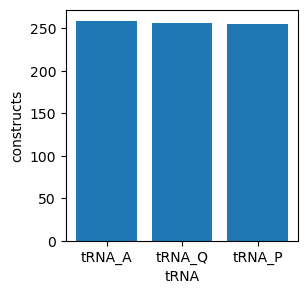

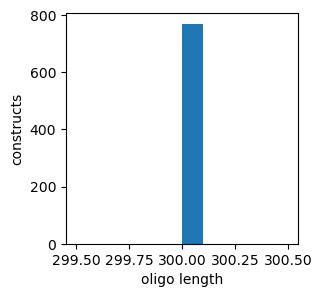

In [14]:
plt.figure(figsize=(3,3))
plt.bar(oligo_design_df.value_counts('tRNA').index, oligo_design_df.value_counts('tRNA').values)
plt.xlabel('tRNA')
plt.ylabel('constructs')
plt.show()

plt.figure(figsize=(3,3))
plt.hist(oligo_design_df.oligo_len)
plt.xlabel('oligo length')
plt.ylabel('constructs')
plt.show()

### save the designs and order the 'oligo' for molecular cloning

In [ ]:
# oligo_design_df.to_csv('oligo_designs/CSM_library_design.%s.csv'%(time.strftime("%Y%m%d-%H%M%S")),index=False)
# oligo_design_df['oligo'].to_csv('oligo_designs/CSM_oligo_order.%s.csv'%(time.strftime("%Y%m%d-%H%M%S")))